# Getting Started with Simulating the Transmission Spectrum

Last update: March 15th (2025) Hajime Kawahara for v2.0

In this getting started guide, we will use ExoJAX to simulate a high-resolution **transmission** spectrum from an atmosphere with CO molecular absorption and hydrogen molecule CIA continuum absorption as the opacity sources. We will then add appropriate noise to the simulated spectrum to create a mock spectrum and perform spectral retrieval using NumPyro's HMC NUTS. 

The author wrote this Jupyter notebook on a gaming laptop equipped with an RTX 3080 GPU, so it is recommended to use a machine with similar or higher GPU specifications. However, except for the HMC NUTS part, the code should also work on lower-spec systems. Now, let’s get started!

First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
from jax import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (`*db`), 
(2) calculating opacity (`opa`),
(3) running atmospheric radiative transfer (`art`),
(4) applying operations on the spectrum (`sop`)

In this "getting started" guide, there are two opacity sources, CO and CIA. Their respective databases, `mdb` and `cdb`, are converted by `opa` into the opacity of each atmospheric layer, which is then used in the radiative transfer calculation performed by `art`. Finally, `sop` convolves instrumental profiles, generating the emission spectrum. 

`mdb`/`cdb` --> `opa` --> `art` --> `sop` ---> spectrum

This spectral model is incorporated into the probabilistic model in NumPyro, and retrieval is performed by sampling using HMC-NUTS.


![Figure. Structure of ExoJAX](https://secondearths.sakura.ne.jp/exojax/figures/exojax_get_started_transmission.png)


## 1. Loading a molecular database using mdb

ExoJAX has an API for molecular databases, called `mdb` (or `adb` for atomic datbases). Prior to loading the database, define the wavenumber range first.

In [2]:
from exojax.utils.grids import wavenumber_grid

nu_grid, wav, resolution = wavenumber_grid(
    22920.0, 23000.0, 3500, unit="AA", xsmode="premodit"
)
print("Resolution=", resolution)

/home/kawahara/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
Resolution= 1004211.9840291934


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:82: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


Then, let's load the molecular database. We here use Carbon monoxide in Exomol. `CO/12C-16O/Li2015` means `Carbon monoxide/ isotopes = 12C + 16O / database name`. You can check the database name in the ExoMol website (https://www.exomol.com/).  

In [3]:
from exojax.spec.api import MdbExomol
mdb = MdbExomol(".database/CO/12C-16O/Li2015", nurange=nu_grid)

/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
radis engine =  vaex
Molecule:  CO
Isotopologue:  12C-16O
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadener:  H2
Broadening code level: a0


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.16-py3.10.egg/radis/api/exomolapi.py:687: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


## 2. Computation of the Cross Section using opa

ExoJAX has various opacity calculator classes, so-called `opa`. Here, we use a memory-saved opa, `OpaPremodit`. We assume the robust tempreature range we will use is 500-1500K.

In [4]:
from exojax.spec.opacalc import OpaPremodit
opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0], dit_grid_resolution=1.0)

OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K


/home/kawahara/exojax/src/exojax/spec/opacalc.py:348: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


# of reference width grid :  2
# of temperature exponent grid : 2
max value of  ngamma_ref_grid : 9.450919102366303
min value of  ngamma_ref_grid : 7.881095721823979
ngamma_ref_grid grid : [7.88109541 9.4509201 ]
max value of  n_Texp_grid : 0.658
min value of  n_Texp_grid : 0.5
n_Texp_grid grid : [0.49999997 0.65800005]


uniqidx: 0it [00:00, ?it/s]

Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [15.12718787427093, 15.23298725175755] cm-1


Then let's compute cross section for two different temperature 500 and 1500 K for P=1.0 bar. opa.xsvector can do that!

In [5]:
P = 1.0  # bar
T_1 = 500.0  # K
xsv_1 = opa.xsvector(T_1, P)  # cm2

T_2 = 1500.0  # K
xsv_2 = opa.xsvector(T_2, P)  # cm2

Plot them. It can be seen that different lines are stronger at different temperatures.

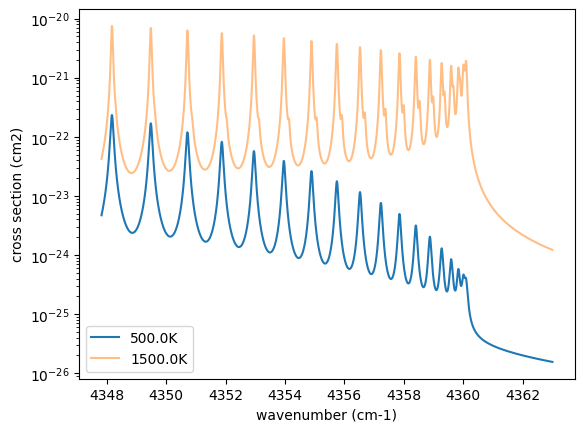

In [6]:
import matplotlib.pyplot as plt

plt.plot(nu_grid, xsv_1, label=str(T_1) + "K")  # cm2
plt.plot(nu_grid, xsv_2, alpha=0.5, label=str(T_2) + "K")  # cm2
plt.yscale("log")
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

## 3. Atmospheric Radiative Transfer

ExoJAX can solve the radiative transfer and derive the transmission spectrum. To do so, ExoJAX has `art` class. `ArtTransPure` means Atomospheric Radiative Transfer for **Transmission** with Pure absorption. So, `ArtTransPure` does not include scattering. You can choose either the trapezoid or Simpson's rule as the integration scheme. The default setting is `integration="simpson"`.
We set the number of the atmospheric layer to 200 (nlayer) and the pressure at bottom and top atmosphere to 1 and 1.e-11 bar.

In [7]:
from exojax.spec.atmrt import ArtTransPure

art = ArtTransPure(
    pressure_btm=1.0e1,
    pressure_top=1.0e-11,
    nlayer=200,
)

integration:  simpson
Simpson integration, uses the chord optical depth at the lower boundary and midppoint of the layers.


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)
/home/kawahara/exojax/src/exojax/spec/atmrt.py:53: UserWarning: nu_grid is not given. specify nu_grid when using 'run' 
  warnings.warn(


Let's assume the power law temperature model, within 500 - 1500 K.

$T = T_0 P^\alpha$

where $T_0=1200$ K and $\alpha=0.1$.

In [8]:
art.change_temperature_range(500.0, 1500.0)
Tarr = art.powerlaw_temperature(1200.0, 0.1)

Also, the mass mixing ratio of CO (MMR) should be defined.

In [9]:
mmr_profile = art.constant_mmr_profile(0.01)

Surface gravity is also important quantity of the atmospheric model, which is a function of planetary radius and mass. Unlike in the case of the emission spectrum, the transmission spectrum is affected by the opacity from the lower to the upper layers of the atmosphere. Therefore, it is better to calculate gravity as a function of altitude. To achieve this, the gravity and radius at the bottom of the atmospheric layer are specified as `gravity_btm` and `radius_btm`, respectively, and the layer-by-layer gravity profile is computed using `art.gravity_profile`.


In [10]:
import jax.numpy as jnp
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.constants import RJ
gravity_btm = gravity_jupiter(1.0, 1.0)
radius_btm = RJ

mmw = 2.33*jnp.ones_like(art.pressure)  # mean molecular weight of the atmosphere
gravity = art.gravity_profile(Tarr, mmw, radius_btm, gravity_btm)


When visualized, it looks like this.

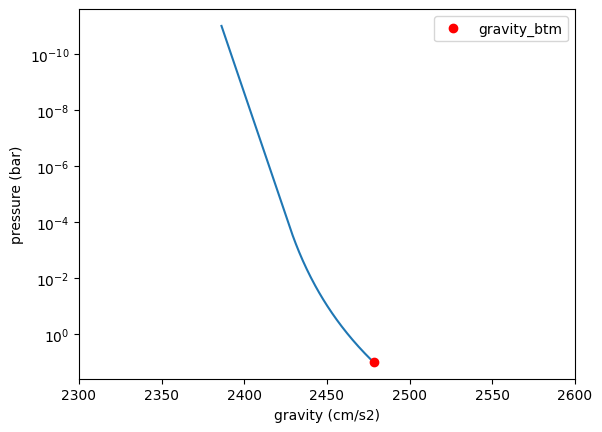

In [11]:

plt.plot(gravity, art.pressure)
plt.plot(gravity_btm, art.pressure[-1], "ro", label="gravity_btm")
plt.yscale("log")
plt.xlim(2300,2600)
plt.gca().invert_yaxis()
plt.xlabel("gravity (cm/s2)")
plt.ylabel("pressure (bar)")
plt.legend()
plt.show()

In addition to the CO cross section, we would consider [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity. `cdb` class can be used.

In [12]:
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA

cdb = CdbCIA(".database/H2-H2_2011.cia", nurange=nu_grid)
opacia = OpaCIA(cdb, nu_grid=nu_grid)

H2-H2


Before running the radiative transfer, we need cross sections for layers, called `xsmatrix` for CO and `logacia_matrix` for CIA (strictly speaking, the latter is not cross section but coefficient because CIA intensity is proportional density square). See [here](CIA_opacity.html) for the details.

In [13]:
xsmatrix = opa.xsmatrix(Tarr, art.pressure)
logacia_matrix = opacia.logacia_matrix(Tarr)

Convert them to opacity

In [14]:


dtau_CO = art.opacity_profile_xs(xsmatrix, mmr_profile, mdb.molmass, gravity)
vmrH2 = 0.855  # VMR of H2
dtaucia = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2, mmw[:, None], gravity)

Add two opacities.

In [15]:
dtau = dtau_CO + dtaucia

In [16]:
gravity_btm

2478.57730044555

Then, run the radiative transfer.
As you can see, the emission spectrum has been generated. This spectrum shows a region near 4360 cm-1, or around 22940 AA, where CO features become increasingly dense. This region is referred to as the band head. If you're interested in why the band head occurs, please refer to [Quatum states of Carbon Monoxide and Fortrat Diagram](Fortrat.html).


In [17]:
Rp2 = art.run(dtau, Tarr, mmw, radius_btm, gravity_btm)
Rp = jnp.sqrt(Rp2)

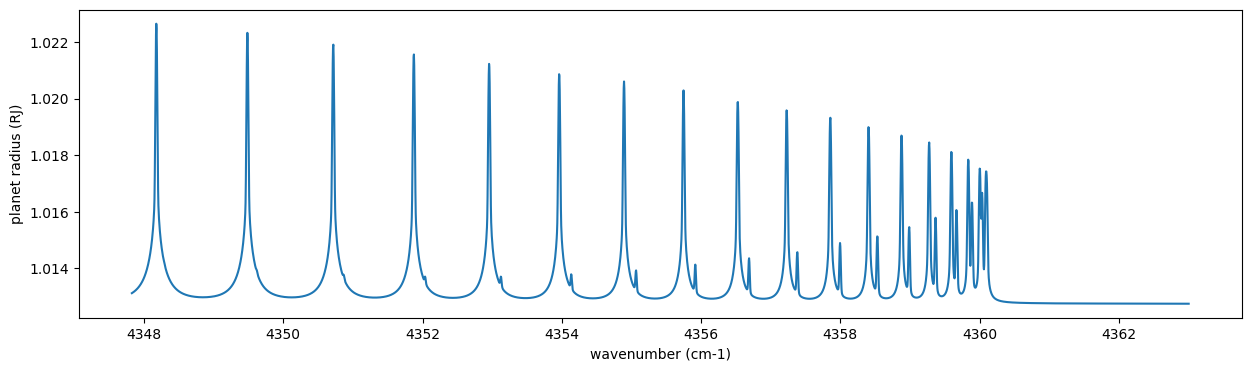

In [18]:
fig = plt.figure(figsize=(15, 4))
plt.plot(nu_grid, Rp)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("planet radius (RJ)")
plt.show()

To examine the contribution of each atmospheric layer to the transmission spectrum, one can, for example, look at the optical depth along the chord direction. This can be done as follows:

In [19]:
from exojax.spec.opachord import chord_geometric_matrix
from exojax.spec.opachord import chord_optical_depth

normalized_height, normalized_radius_lower = art.atmosphere_height(Tarr, mmw, radius_btm, gravity_btm)        
cgm = chord_geometric_matrix(normalized_height, normalized_radius_lower)
dtau_chord = chord_optical_depth(cgm, dtau)


By plotting the data, it becomes clear that in the case of transmitted light, information from a wide range of atmospheric layers, from the upper to the lower layers, is included.

/home/kawahara/exojax/src/exojax/plot/atmplot.py:24: UserWarning: nugrid looks in log scale, results in a wrong X-axis value. Use log10(nugrid) instead.
  warnings.warn(


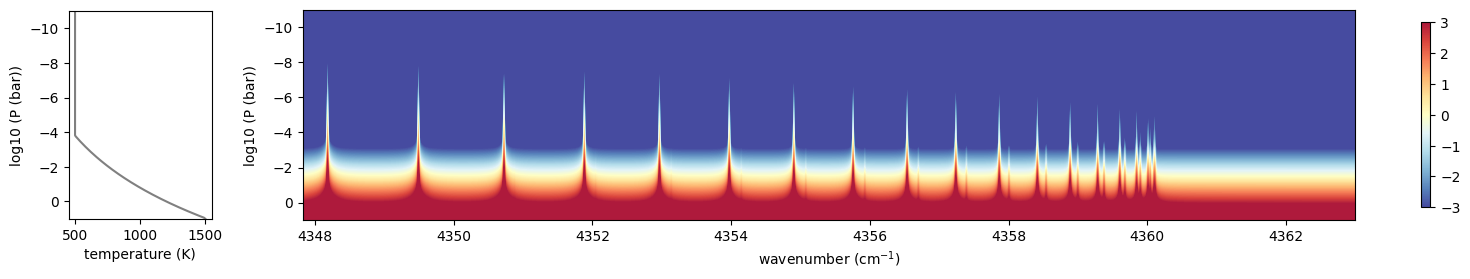

In [20]:
from exojax.plot.atmplot import plottau
plottau(nu_grid, dtau_chord, Tarr, art.pressure)

## 4. Spectral Operators:　instrumental profile, Doppler velocity shift and so on, any operation on spectra.

The above spectrum is called "raw spectrum" in ExoJAX. The effects applied to the raw spectrum is handled in ExoJAX by the spectral operator (`sop`).

Then, the instrumental profile with relative radial velocity shift is applied. Also, we need to match the computed spectrum to the data grid. This process is called `sampling` (but just interpolation though). Below, let’s perform a simulation that includes noise for use in later analysis.

In [21]:
from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std

sop_inst = SopInstProfile(nu_grid, vrmax=1000.0)

RV = 40.0  # km/s
resolution_inst = 30000.0
beta_inst = resolution_to_gaussian_std(resolution_inst)
Rp2_inst = sop_inst.ipgauss(Rp2, beta_inst)
nu_obs = nu_grid[::5][:-50]


from numpy.random import normal
noise = 0.001
Fobs = sop_inst.sampling(Rp2_inst, RV, nu_obs) + normal(0.0, noise, len(nu_obs))

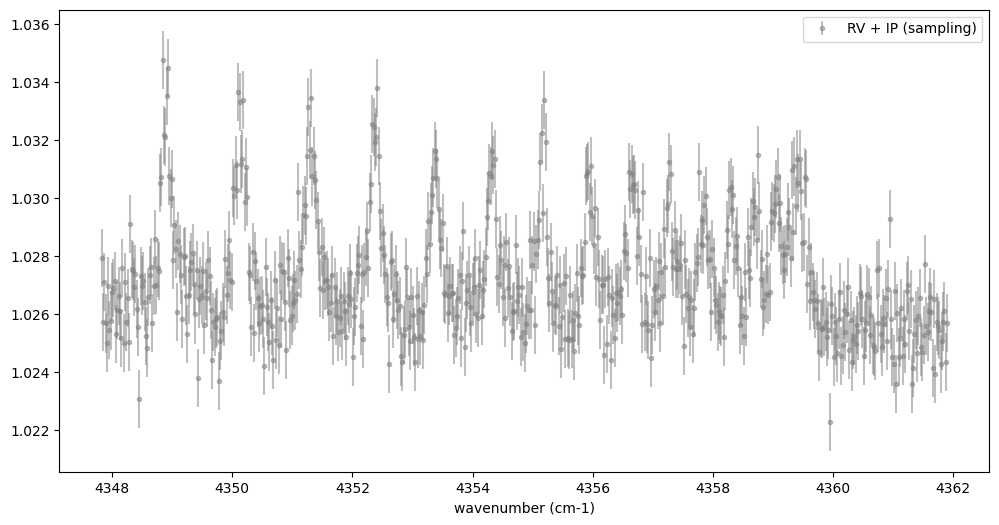

In [22]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

plt.errorbar(nu_obs, Fobs, noise, fmt=".", label="RV + IP (sampling)", color="gray",alpha=0.5)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.show()

## 5. Retrieval of an Emission Spectrum

Next, let’s perform a “retrieval” on the simulated spectrum created above. Retrieval involves estimating the parameters of an atmospheric model in the form of a posterior distribution based on the spectrum. To do this, we first need a model. Here, we have compiled the forward modeling steps so far and defined the model as follows. The spectral model has six parameters.

In [23]:
def fspec(T0, alpha, mmr, radius_btm, gravity_btm, RV):
    
    Tarr = art.powerlaw_temperature(T0, alpha)
    gravity = art.gravity_profile(Tarr, mmw, radius_btm, gravity_btm)
    
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(mmr)
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, gravity)
    #continuum
    logacia_matrix = opacia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw[:, None], gravity)
    #total tau
    dtau = dtau + dtaucH2H2
    Rp2 = art.run(dtau, Tarr, mmw, radius_btm, gravity_btm)
    Rp2_inst = sop_inst.ipgauss(Rp2, beta_inst)

    mu = sop_inst.sampling(Rp2_inst, RV, nu_obs)
    return mu

Let’s verify that spectra are being generated from `fspec` with various parameter sets.

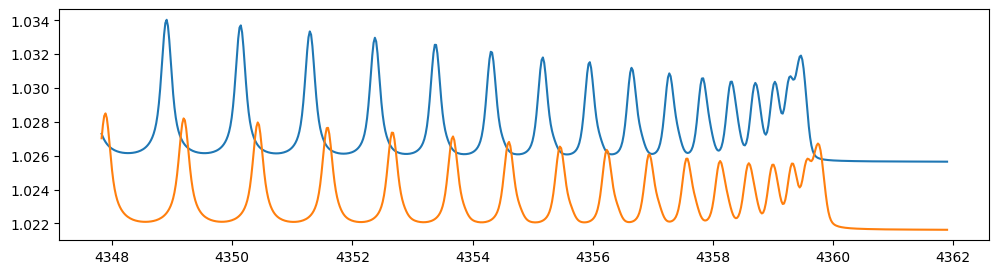

In [24]:
fig = plt.figure(figsize=(12, 3))

plt.plot(nu_obs, fspec(1200.0, 0.09, 0.01, RJ, gravity_jupiter(1.0, 1.0), 40.0),label="model")
plt.plot(nu_obs, fspec(1400.0, 0.12, 0.01, RJ, gravity_jupiter(1.0, 1.3), 20.0),label="model")

NumPyro is a probabilistic programming language (PPL), which requires the definition of a probabilistic model. In the probabilistic model `model_prob` defined below, the prior distributions of each parameter are specified. The previously defined spectral model is used within this probabilistic model as a function that provides the mean $\mu$. The spectrum is assumed to be generated according to a Gaussian distribution with this mean and a standard deviation $\sigma$. i.e. $f(\nu_i) \sim \mathcal{N}(\mu(\nu_i; {\bf p}), \sigma^2 I)$, where ${\bf p}$ is the spectral model parameter set, which are the arguments of `fspec`. 



In [25]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro
from jax import random

In [26]:
def model_prob(spectrum):

    #atmospheric/spectral model parameters priors
    logg = numpyro.sample('logg', dist.Uniform(3.0, 4.0))
    RV = numpyro.sample('RV', dist.Uniform(35.0, 45.0))
    mmr = numpyro.sample('MMR', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    radius_btm = numpyro.sample('rb', dist.Normal(1.0,0.05))
    
    mu = fspec(T0, alpha, mmr, radius_btm*RJ, 10**logg, RV)

    #noise model parameters priors
    sigmain = numpyro.sample('sigmain', dist.Exponential(1000.0)) 

    numpyro.sample('spectrum', dist.Normal(mu, sigmain), obs=spectrum)

Now, let’s define NUTS and start sampling. 

In [27]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_prob, forward_mode_differentiation=True)
kernel = NUTS(model_prob, forward_mode_differentiation=False)

Since this process will take several hours, feel free to go for a long lunch break!

In [28]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, spectrum=Fobs)
mcmc.print_summary()

2025-03-16 08:52:36.036681: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 1.12GiB (1197551152 bytes) by rematerialization; only reduced to 4.64GiB (4984396064 bytes), down from 4.64GiB (4984396064 bytes) originally
warmup:   3%|▎         | 51/1500 [06:31<3:05:22,  7.68s/it, 43 steps of size 6.48e-04. acc. prob=0.72]   


KeyboardInterrupt: 

After returning from your long lunch, if you're lucky and the sampling is complete, let’s write a predictive model for the spectrum.

In [ ]:
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import jax.numpy as jnp

In [ ]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_prob, posterior_sample, return_sites=['spectrum'])
predictions = pred(rng_key_, spectrum=None)
median_mu1 = jnp.median(predictions['spectrum'], axis=0)
hpdi_mu1 = hpdi(predictions['spectrum'], 0.9)

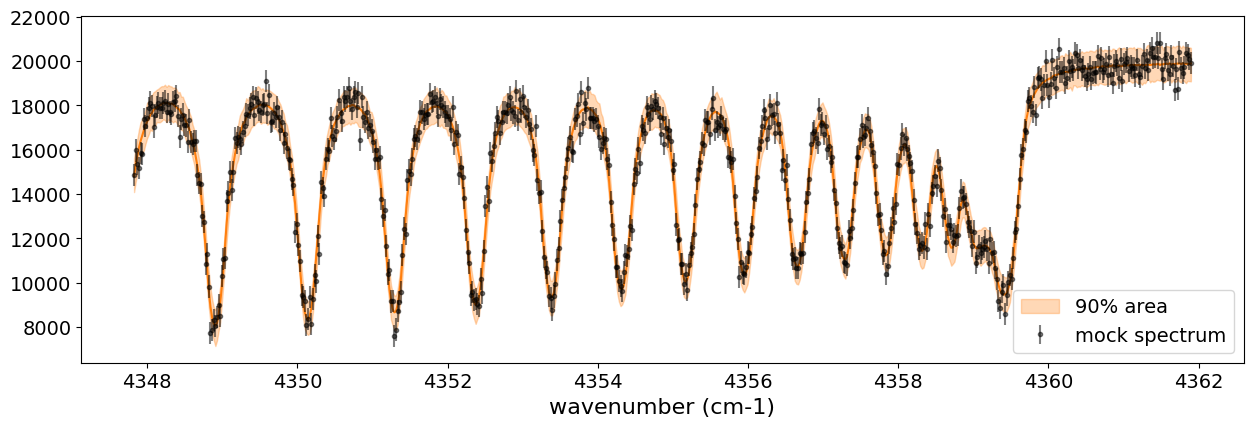

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_mu1, color='C1')
ax.fill_between(nu_obs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

You can see that the predictions are working very well! Let’s also display a corner plot. Here, we’ve used ArviZ for visualization.

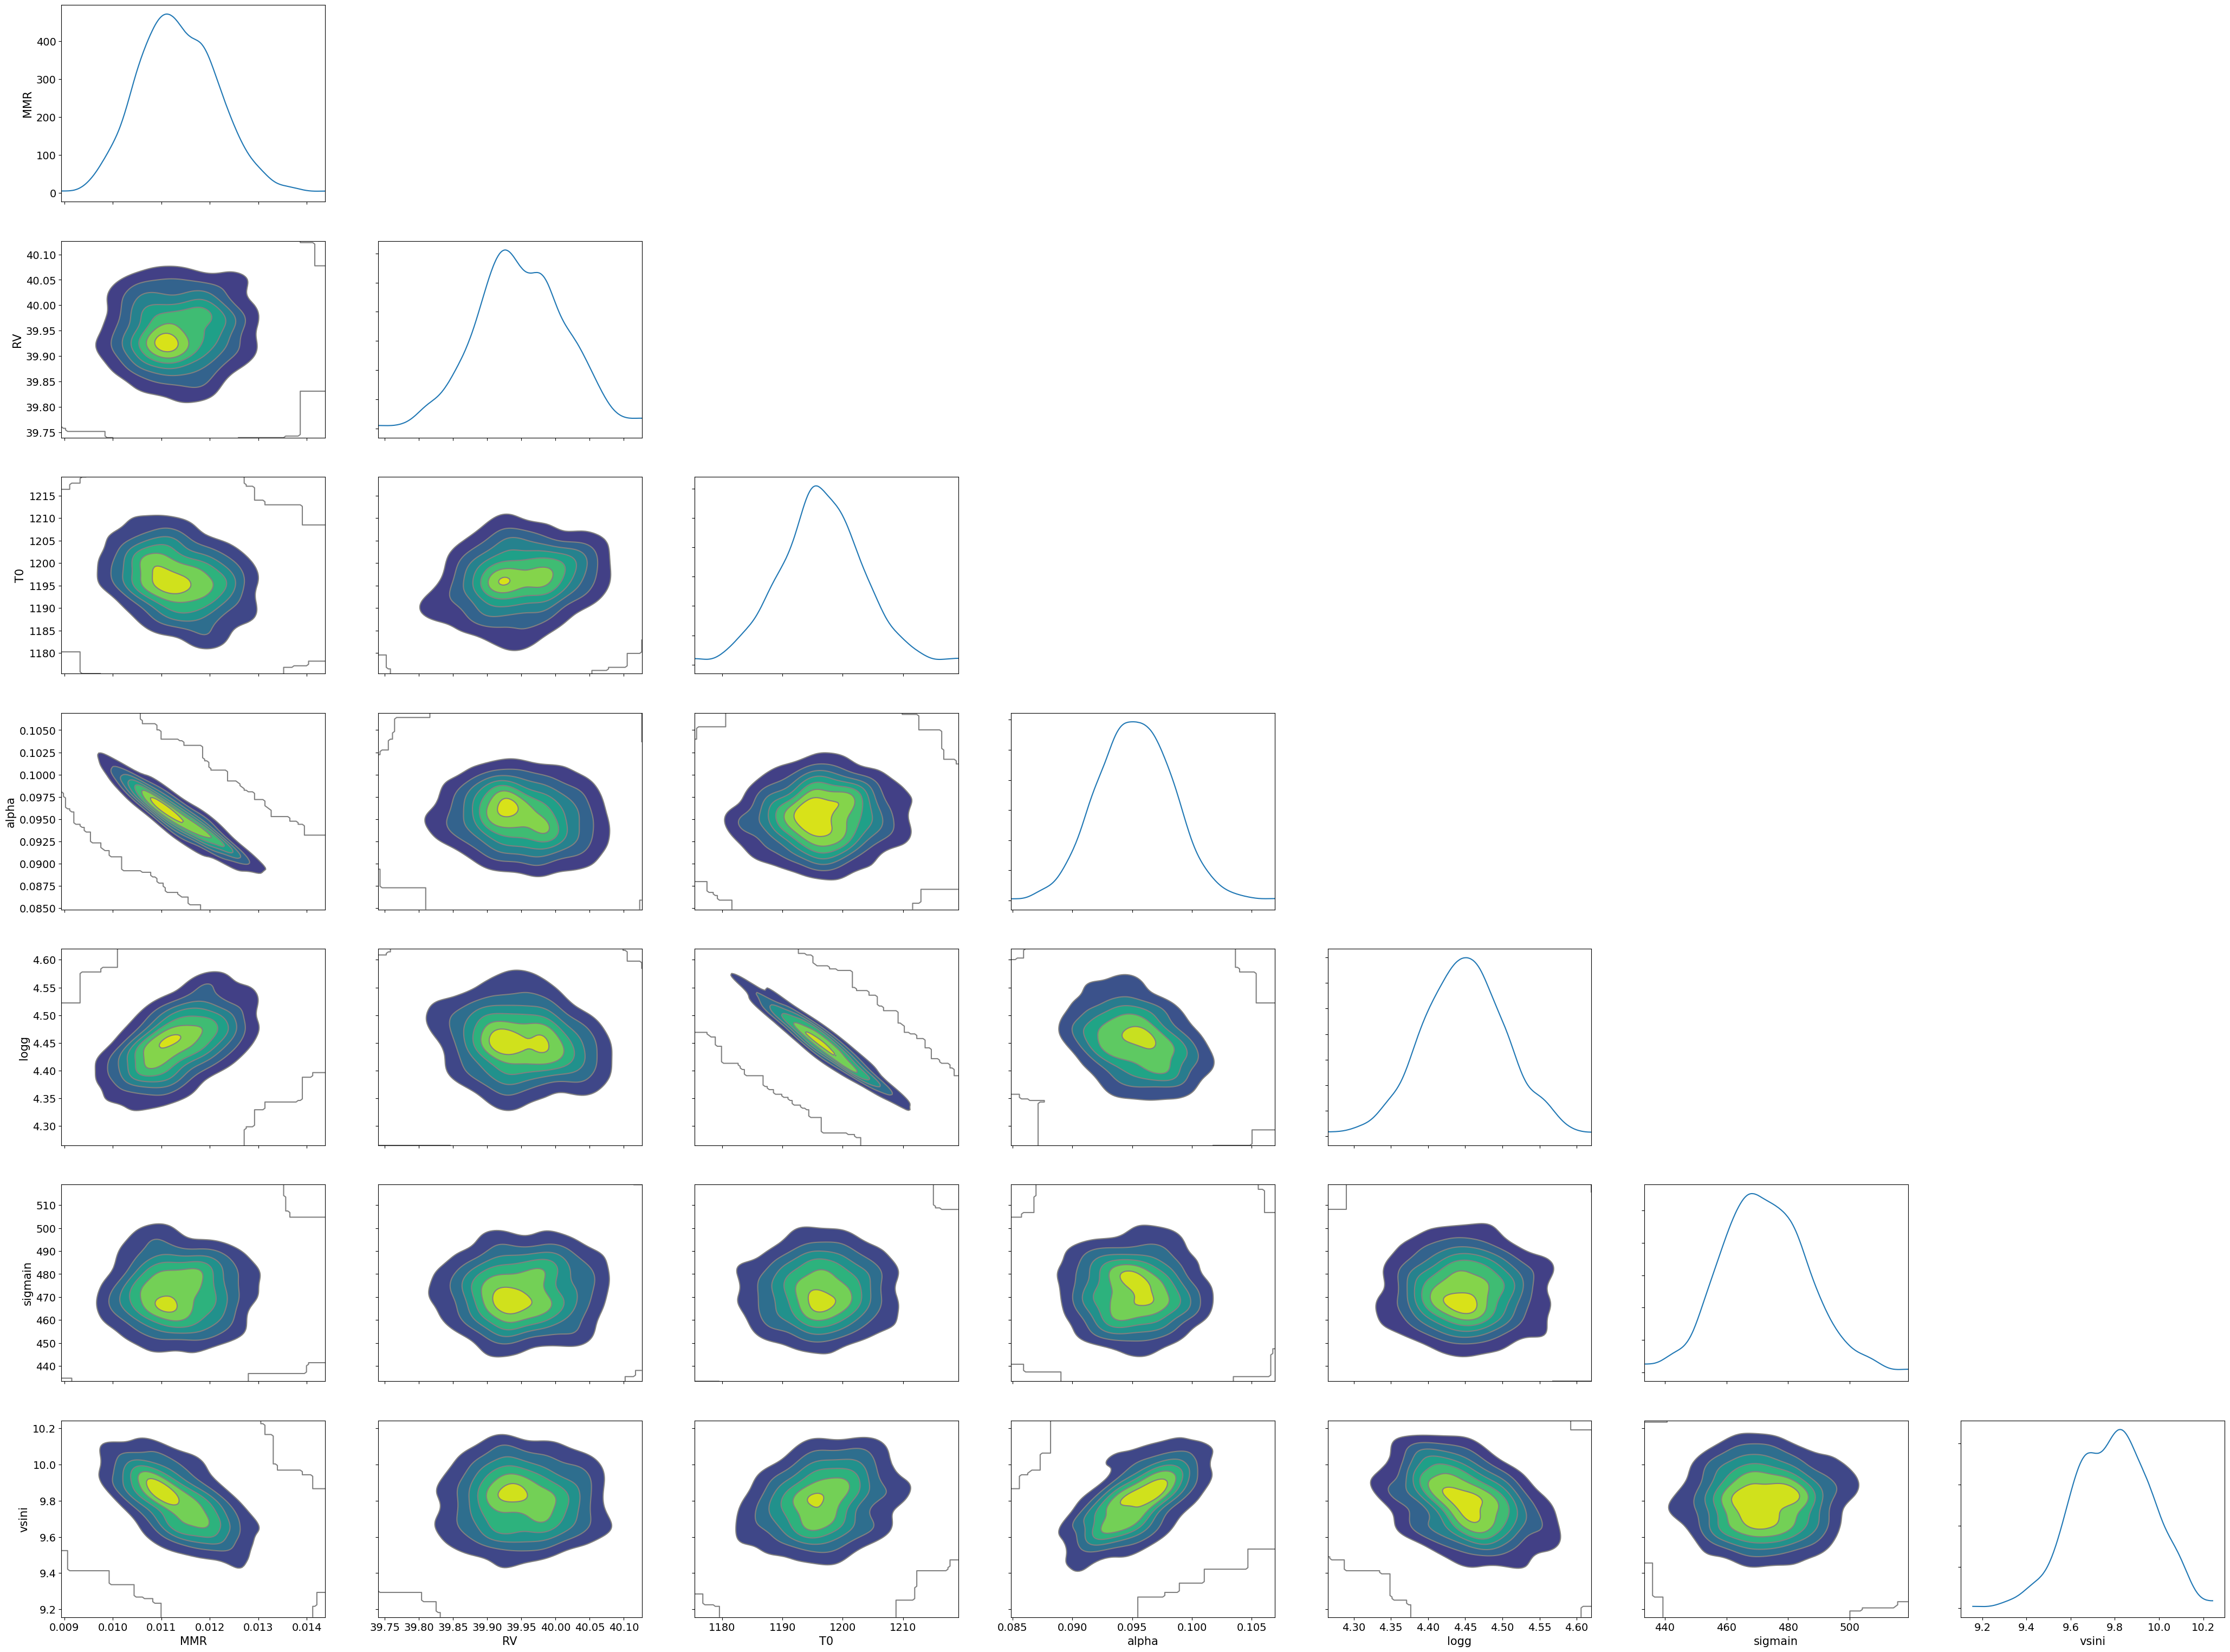

In [ ]:
import arviz
pararr = ['T0', 'alpha', 'logg', 'MMR', 'radius_btm', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.show()